In [2]:
import numpy as np
from math import pi, sqrt
from matplotlib import pyplot
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

In [3]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=1*hwc #1e2*meV
mu_sc=5*hwc #1e2*meV
D_sc=0.5*hwc #10*meV
nu=0.4#sqrt(2)+0.1
mu_n=nu*hwc #10*meV

lambd=.0*vF
gs=0.*hwc
gn=0.1*hwc

Lx=8*lB

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])


def system_E_vs_k(k0,Nx=100,U0=0,Ls=Lx):
    ky_sw=k0/lB
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    def y2(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
        return c

    def y1(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
        return c

    def y0(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
        return c

    def y0s(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
        return c
    
    def y0c(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 4*np.sin(k*Ls/4)**2/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = 0
        return c

    Hx= hbar*vF*np.kron(np.diag(kx) , sigma2)
    HeB= -2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma1)
    HeBT= -2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma1)

    Hxm= np.kron( y0s(k1-k2) , m_sc*sigma3)
    HxmT= np.kron( y0s(k2-k1) , m_sc*sigma3)
    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

    Hd= np.kron(D_sc*y0s(k1-k2),sigma0)
    # basis ud,ud
    dmat=np.array([[0.,1.],[0.,0.]])
    ddmat=np.kron(dmat,np.array([[0.,1.],[-1.,0.]]))
    Hd_mat=np.kron(ddmat,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

    Hlx=hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron(k1*y0s(k1-k2),sigma0) )
    HlxT=-hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron(k1*y0s(k2-k1),sigma0) )
    Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
    Hz= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
    HzT= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_upT,sigma0) )

    
    En=np.zeros(ky_sw.shape)
    for i_k in range(len(ky_sw)):
        ky=ky_sw[i_k]
        Hy= np.kron(hbar*vF*ky*np.eye(Nx), sigma1)

        H1 = Hx +Hy + HeB + Hxm + Hef
        H1T = Hx -Hy + (HeBT + HxmT + HefT).conj()

#         Hly=hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k1-k2),sigma0) )
#         HlyT=-hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k2-k1),sigma0) )

        H_p=block_diag(H1,H1)+Hlx+Hz
        H_pT=block_diag(H1T,H1T)+(HlxT+HzT).conj()

        H_t=block_diag(H_p,-H_pT)+Hd_mat
        Evals, _ =np.linalg.eigh(H_t)
        En[i_k]=Evals[4*Nx]/hwc
    return En


def system_builder(k0,Nx=100,U0=0,Ls=Lx):
    ky=k0/lB
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    def y2(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
        return c

    def y1(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
        return c

    def y0(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
        return c

    def y0s(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
        return c

    Hx= hbar*vF*np.kron(np.diag(kx) , sigma2)
    HeB= -2j*vF*elec*B* np.kron(np.imag(y1(k1-k2)), sigma1)
    HeBT= -2j*vF*elec*B* np.kron(np.imag(y1(k2-k1)), sigma1)

    Hxm= np.kron( y0s(k1-k2) , m_sc*sigma3)
    HxmT= np.kron( y0s(k2-k1) , m_sc*sigma3)
    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1), sigma0 )

    Hd= np.kron(D_sc*y0s(k1-k2),sigma0)
    # basis ud,ud
    dmat=np.array([[0.,1.],[0.,0.]])
    ddmat=np.kron(dmat,np.array([[0.,1.],[-1.,0.]]))
    Hd_mat=np.kron(ddmat,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

    Hlx=hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron(k1*y0s(k1-k2),sigma0) )
    HlxT=-hbar*lambd*np.kron(np.array([[0.,-1j],[1j,0.]]), np.kron(k1*y0s(k2-k1),sigma0) )
    Hz_up= -(gs*y0s(k1-k2)+2*gn*np.real(y0(k1-k2)))
    Hz= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1)+2*gn*np.real(y0(k2-k1)))
    HzT= np.kron(np.array([[1,0],[0,-1]]), np.kron(Hz_upT,sigma0) )


    Hy= np.kron(hbar*vF*ky*np.eye(Nx), sigma1)

    H1 = Hx +Hy + HeB + Hxm + Hef
    H1T = Hx -Hy + (HeBT + HxmT + HefT).conj()

#     Hly=hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k1-k2),sigma0) )
#     HlyT=-hbar*lambd*ky*np.kron(np.array([[0.,1],[1,0.]]), np.kron(y0s(k2-k1),sigma0) )
 
    H_p=block_diag(H1,H1)+Hlx+Hz
    H_pT=block_diag(H1T,H1T)+(HlxT+HzT).conj()
    
    H_t=block_diag(H_p,-H_pT)+Hd_mat

    
    En, Vs =np.linalg.eigh(H_t)

    return kx,En[[4*Nx-1,4*Nx]],Vs[:,[4*Nx-1,4*Nx]]

def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:4*Nx,:]
    ev_h= ev[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])



Comparison with Andreev Edge state

In [5]:
t_timer=time.time()

x0_kmin=1.8#-1.50

# Ls_sw=np.linspace(2,10,40)*lB
# Ls_sw=np.arange(2,11)*lB
Ls_sw=np.array([6])*lB
Nx2=200

# kmin=x0_kmin-0.2
# kmax=x0_kmin+0.2
# ky_sw=np.linspace(kmin,kmax,80)
ky_sw=np.linspace(0,3,40)#*2.0*np.sign(x0_kmin)
Ek2= np.zeros((len(ky_sw),len(Ls_sw)))
Eg_mat= np.zeros(len(Ls_sw))

Vp= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
Vh= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
kpt=np.zeros(len(Ls_sw))
for i_L in range(len(Ls_sw)):
    print(i_L, end='\r')
    Ls=Ls_sw[i_L]
    U2=0*hwc

#     f2=minimize(system_E_vs_k,x0=x0_kmin,args=(Nx2,U2,Ls))
#     kx2,Em,Vm= system_builder(f2.x[0],Nx=Nx2,U0=U2,Ls=Ls)
#     kpt[i_L]=f2.x[0]
#     Eg_mat[i_L]=f2.fun
    Ek2[:,i_L]=system_E_vs_k(k0=ky_sw,Nx=Nx2,U0=0,Ls=Ls)

    
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

Finished, elapsed time = 16 sec


In [6]:
def plot_bands(i_L):
    pyplot.figure()
    pyplot.plot(ky_sw,Ek2[:,i_L],'b')
    pyplot.plot(kpt[i_L],Eg_mat[i_L],'ro')
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.show()

interact(plot_bands, i_L=(0,len(Ls_sw)-1,1));

interactive(children=(IntSlider(value=0, description='i_L', max=0), Output()), _dom_classes=('widget-interact'…

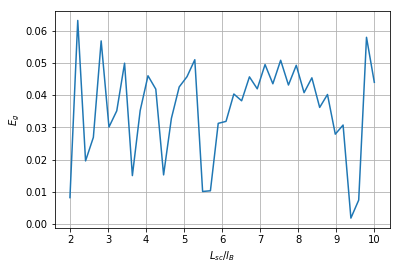

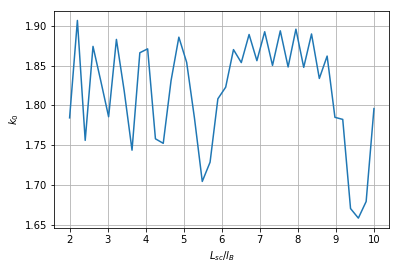

In [10]:
pyplot.figure()
pyplot.plot(Ls_sw/lB,Eg_mat)
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.grid()
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$E_g$")
pyplot.show()

pyplot.figure()
pyplot.plot(Ls_sw/lB,kpt)
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.grid()
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$k_0$")
pyplot.show()

# ratio=np.tan(abs(np.angle(Vp/Vh).T))**2
# pyplot.figure()
# # pyplot.plot(Ls_sw/lB,np.mod(np.angle(Vp/Vh).T/pi,1))
# pyplot.plot(Ls_sw/lB,np.abs(np.tan(theta)))
# # pyplot.plot(Ls_sw/lB,np.abs(Vp).T)
# # pyplot.plot(Ls_sw/lB,np.abs(Vh).T)
# # pyplot.plot(Ls_sw/lB,np.angle(Vp/Vh).T/pi)
# # pyplot.plot(Ls_sw/lB,ratio/(1+ratio))
# # pyplot.plot(Ls_sw/lB,Vh)
# pyplot.ylim([0.,0.1])
# pyplot.grid()
# pyplot.ylabel("p/h components")
# pyplot.xlabel(r"$k0*l_B$")
# pyplot.show()
# print(np.abs(theta/pi))

In [92]:
# f1=minimize(system_E_vs_k,x0=0.8,args=(Nx1,U1,Ls1))
# kx1,Eb,Vb= system_builder(1.1*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
# wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)

def plot_wf(i_L):
    iwf=0
    pyplot.figure()
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf1_h_arr[:,i_L])**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_p_arr[:,iwf,i_L])**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_h_arr[:,iwf,i_L])**2/2)
#     pyplot.plot(x0/lB,np.real(wf2_p_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.imag(wf2_p_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.real(wf2_h_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.imag(wf2_h_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.abs(wf2_h_arr[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
#     pyplot.ylim([0,0.01])
    pyplot.show()
    
interact(plot_wf, i_L=(0,len(Ls_sw)-1,1));

interactive(children=(IntSlider(value=39, description='i_L', max=79), Output()), _dom_classes=('widget-interac…

In [6]:
Nx1=100
U1=100*hwc
Ls1=20*lB
# x0_kmin=[0.3,0.9,1.50,2.2]
x0=np.linspace(-1,1,1000)*20*lB


def plot_wf(i_L,x0_kmin):
    f1=minimize(system_E_vs_k,x0=x0_kmin,args=(Nx1,U1,Ls1))
    print(f1.x[0])
    kx1,Eb,Vb= system_builder((1.+0.1*np.sign(f1.x[0]))*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
    wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)
    print(np.linalg.norm(wf1_p))
    
    iwf=0
    pyplot.figure()
    pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2/2)
    pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2/2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.imag(wf1_p))
# #     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.imag(wf2_p[:,iwf,i_L]))
#     pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
#     pyplot.ylim([0,0.004])
    pyplot.show()
    
# interact(plot_wf, i_L=(0,len(Ls_sw)-1,1), x0_kmin=[0.3,0.9,1.50,2.2]);
# interact(plot_wf, i_L=(0,len(Ls_sw)-1,1), x0_kmin=[0.5,1.2]);

0.5214686612135789
0.9999978512882425


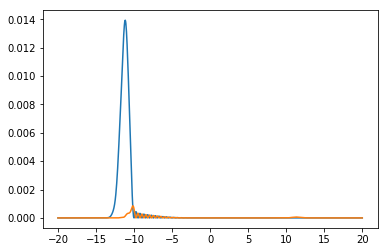

In [111]:
plot_wf(i_L=0,x0_kmin=0.5)